<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 1 - Profiles extraction </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Profiles creation and data extraction from DSM and orthophotos</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">The first steps in a typical workflow is to create cross-shore transects in all the locations and extract elevation and RGB information along those transects. Sandpiper allows the data extraction from hundreds of rasters at once, in an organised way. <br>

<b>This notebook covers the following concepts:</b>

- Naming conventions and global parameters.
- Setting up the folders.
- Setting up the folders.
</font>


</font>

Import all it is required.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle
from tqdm.notebook import tqdm

from sandpyper.profile import ProfileSet
from sandpyper.hotspot import ProfileDynamics

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
dirNameDSM=r'C:\my_packages\sandpyper\tests\test_data\dsm_1m'
dirNameOrtho=r'C:\my_packages\sandpyper\tests\test_data\orthos_1m'
dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'
transects_spacing=20

loc_codes=["mar","leo"]
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }
lod_mode=r"C:\my_packages\sandpyper\tests\test_data\lod_transects"

D=pickle.load(open(r"C:\my_packages\sandpyper\tests\test_data\test.p", "rb"))

loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

In [3]:
D.compute_multitemporal(loc_full={'mar': 'Marengo',
         'leo': 'St. Leonards'}, filter_class='sand')

Filter activated: only ['sand'] points will be retained.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
done
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
done


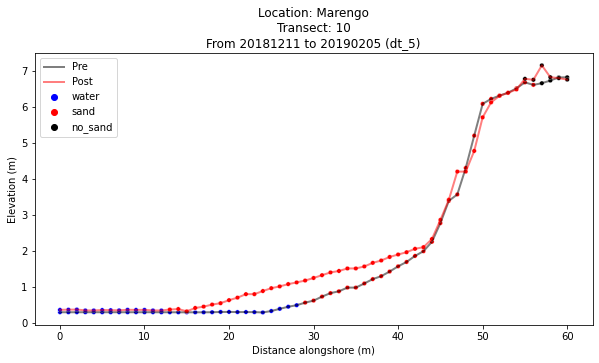

In [4]:
D.plot_transects(location='mar',tr_id=10, dt='dt_5', classified=True)

Working on leo at dt_0


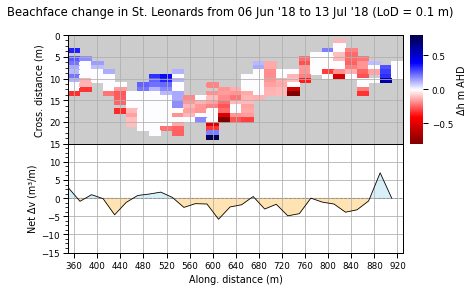

Working on leo at dt_1


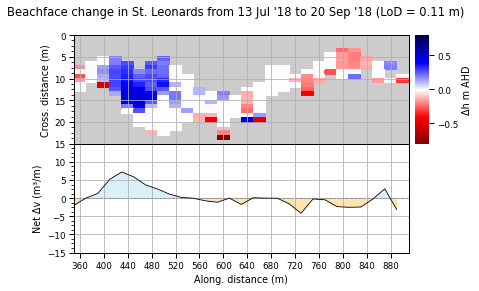

Working on leo at dt_2


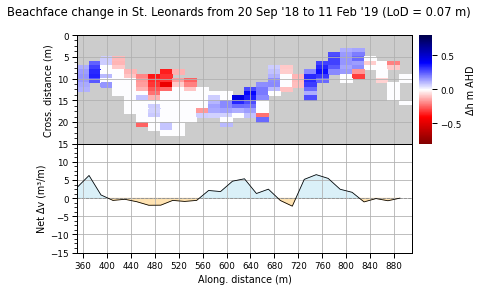

In [5]:
mode="subset" # if 'subset', only the provided location_subset and dt_subset will be plotted. If 'all', plot all.
location_subset=['leo'] # provide a list of location codes. Only these locations will be plotted
y_heat_bottom_limit=25 # bottom limit of the heatmaps (altimetric change)
heat_yticklabels_freq=5
heat_xticklabels_freq=2
ax2_y_lims=[-15,15] # axis limit of the alongshore volumetric plot
dt_subset=["dt_0", "dt_1","dt_2"]

D.plot_alongshore_change(mode=mode, lod=D.lod_df,dt_subset=dt_subset,
                        location_subset=location_subset,
                        y_heat_bottom_limit=y_heat_bottom_limit,
                        heat_yticklabels_freq=heat_yticklabels_freq,
                         heat_xticklabels_freq=heat_xticklabels_freq,
                        ax2_y_lims=ax2_y_lims)

Statistics are computed based on the following classes only: sand


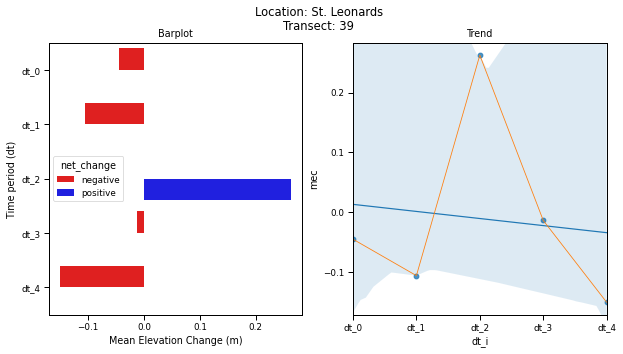

In [6]:
D.plot_transect_mecs('leo',tr_id=39)

Using LoDs.
Statistics are computed based on the following classes only: sand


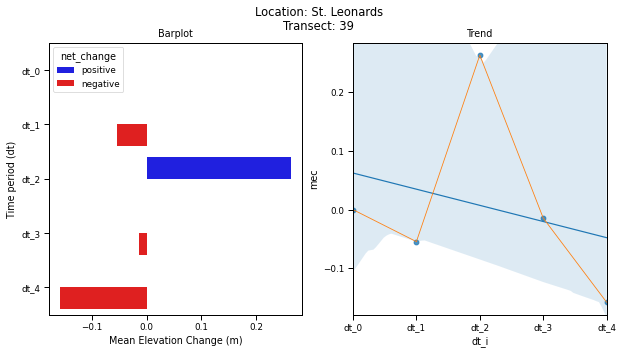

In [7]:
D.plot_transect_mecs('leo',tr_id=39, lod=D.lod_df)

In [8]:
D.compute_volumetrics(lod=D.lod_df)
D.location_volumetrics

Using LoDs.


,location,location_full,dt,date_from,date_to,n_days,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,leo,St. Leonards,dt_0,20180606,20180713,37,9.489928,-20.506530,-11.016602,-0.018994,0.041082,-0.088773,-0.047691,134.334184,-362.662966,-228.328782,-0.393670,231
1,leo,St. Leonards,dt_1,20180713,20180920,69,18.725955,-9.525609,9.200346,0.016429,0.085507,-0.043496,0.042011,322.445395,-103.237953,219.207442,0.391442,219
2,leo,St. Leonards,dt_2,20180920,20190211,144,15.840791,-7.481373,8.359419,0.014928,0.076158,-0.035968,0.040190,285.138428,-138.500707,146.637721,0.261853,208
3,leo,St. Leonards,dt_3,20190211,20190328,45,10.163696,-11.862978,-1.699282,-0.002930,0.040015,-0.046705,-0.006690,181.204725,-171.608277,9.596448,0.016546,254
4,leo,St. Leonards,dt_4,20190328,20190731,125,6.105440,-29.049858,-22.944418,-0.040972,0.026896,-0.127973,-0.101077,89.599553,-511.175997,-421.576444,-0.752815,227
5,mar,Marengo,dt_0,20180601,20180621,20,47.933825,-30.648133,17.285693,0.041156,0.127824,-0.081728,0.046095,1030.634869,-606.379918,424.254951,1.010131,375
6,mar,Marengo,dt_1,20180621,20180727,36,25.375054,-46.167231,-20.792177,-0.049505,0.066776,-0.121493,-0.054716,536.013932,-1095.568154,-559.554222,-1.332272,380
7,mar,Marengo,dt_2,20180727,20180925,60,144.146997,-38.435384,105.711614,0.251694,0.367722,-0.098049,0.269672,2860.189079,-760.660241,2099.528838,4.998878,392
8,mar,Marengo,dt_3,20180925,20181113,49,25.104553,-35.649872,-10.545319,-0.023967,0.105040,-0.149163,-0.044123,492.032262,-717.083270,-225.051008,-0.511480,239
9,mar,Marengo,dt_4,20181113,20181211,28,48.356887,-4.653221,43.703666,0.099327,0.209337,-0.020144,0.189193,893.964017,-141.652205,752.311812,1.709800,231


In [9]:
D.compute_volumetrics(lod=None)
D.location_volumetrics

No LoD is used.


,location,location_full,dt,date_from,date_to,n_days,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,leo,St. Leonards,dt_0,20180606,20180713,37,10.780268,-24.284117,-13.503849,-0.023282,0.046668,-0.105126,-0.058458,161.424279,-412.611120,-251.186841,-0.433081,231
1,leo,St. Leonards,dt_1,20180713,20180920,69,21.267284,-12.117579,9.149705,0.016339,0.097111,-0.055331,0.041779,398.406102,-226.489170,171.916932,0.306995,219
2,leo,St. Leonards,dt_2,20180920,20190211,144,17.467638,-8.667006,8.800633,0.015715,0.083979,-0.041668,0.042311,315.169727,-162.549841,152.619886,0.272536,208
3,leo,St. Leonards,dt_3,20190211,20190328,45,12.901464,-15.390281,-2.488818,-0.004291,0.050793,-0.060592,-0.009798,232.762552,-312.694975,-79.932423,-0.137815,254
4,leo,St. Leonards,dt_4,20190328,20190731,125,8.866640,-30.546565,-21.679925,-0.038714,0.039060,-0.134566,-0.095506,153.094085,-547.058372,-393.964288,-0.703508,227
5,mar,Marengo,dt_0,20180601,20180621,20,48.403241,-30.995711,17.407530,0.041446,0.129075,-0.082655,0.046420,943.599043,-574.868174,368.730869,0.877931,375
6,mar,Marengo,dt_1,20180621,20180727,36,26.479430,-47.273284,-20.793854,-0.049509,0.069683,-0.124403,-0.054721,576.160199,-1003.503621,-427.343422,-1.017484,380
7,mar,Marengo,dt_2,20180727,20180925,60,144.350869,-38.735969,105.614900,0.251464,0.368242,-0.098816,0.269426,2851.596266,-787.524362,2064.071904,4.914457,392
8,mar,Marengo,dt_3,20180925,20181113,49,26.021678,-37.765560,-11.743882,-0.026691,0.108877,-0.158015,-0.049138,529.991364,-748.863161,-218.871797,-0.497436,239
9,mar,Marengo,dt_4,20181113,20181211,28,49.528444,-6.219476,43.308968,0.098429,0.214409,-0.026924,0.187485,924.691201,-176.441171,748.250030,1.700568,231


Color dictionary provided.


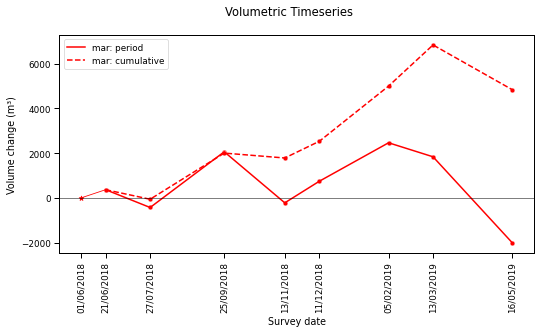

In [10]:
D.plot_single_loc(['mar'], colors_dict=colors_dict)

Color dictionary provided.


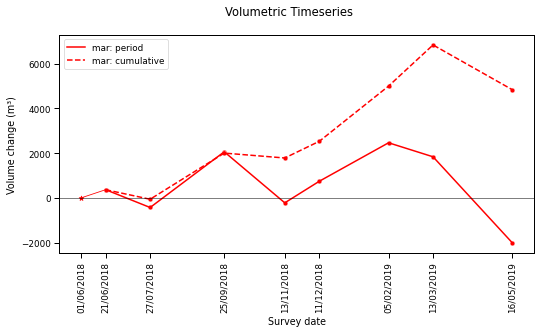

In [11]:
D.plot_single_loc(['mar'], colors_dict=colors_dict)

Statistics are computed based on the following classes only: sand


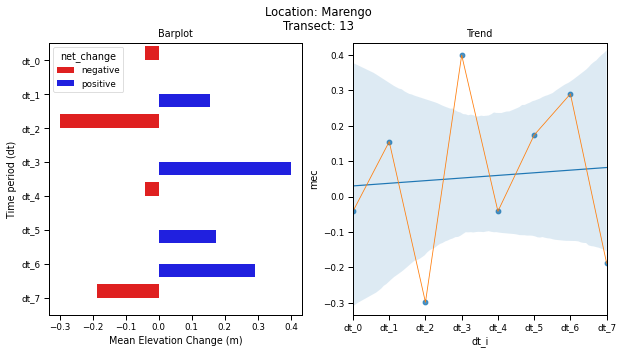

In [12]:
D.plot_transect_mecs('mar',tr_id=13)

### Sensitivity Analysis r-bcd transects

In [24]:
loc_specs={'mar':{'thresh':6,
       'min_points':6}}

In [40]:
ss_tr_big = sensitivity_tr_rbcd(D.df_labelled,
                                test_thresholds='max',
                                test_min_pts=[0,20,2])

Working on mar.
A total of 90 combinations of thresholds and min_pts will be computed.


  0%|          | 0/90 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
errore
Working on threshold 0 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 0 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 8 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 0 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
errore
Working on threshold 7 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 8 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 0 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
Working on threshold 7 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 8 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 0 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
Working on threshold 7 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on threshold 8 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
tr_id 23 has 0 valid points.
tr_id 22 has 0 valid points.
tr_id 21 has 0 valid points.
tr_id 20 has 0 valid points.
tr_id 5 has 0 valid points.
tr_id 4 has 0 valid points.
tr_id 3 has 0 valid points.
Working on leo.
A total of 60 combinations of thresholds and min_pts will be computed.


  0%|          | 0/60 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 2.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 4.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 4.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 6.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 8.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

Working on threshold 2 and min points 10.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 0 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 5 and min points 12.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 3 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
errore
Working on threshold 4 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 14.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 1 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 2 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

Working on threshold 3 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 4 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 16.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 0 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 1 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

errore
Working on threshold 2 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

Working on threshold 3 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 4 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.
Working on threshold 5 and min points 18.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 46 has 0 valid points.


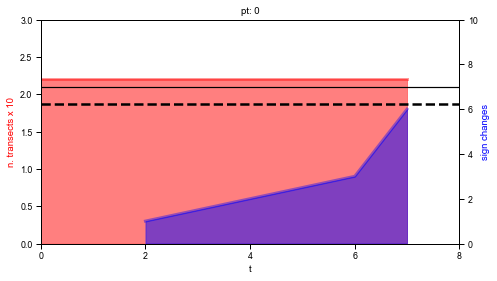

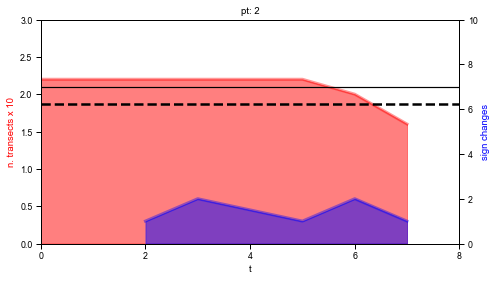

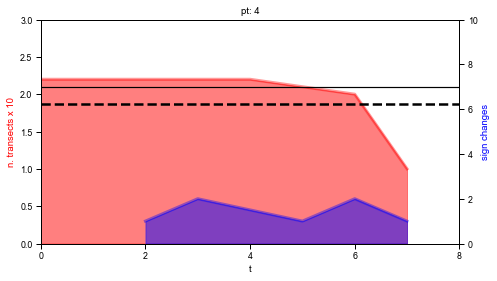

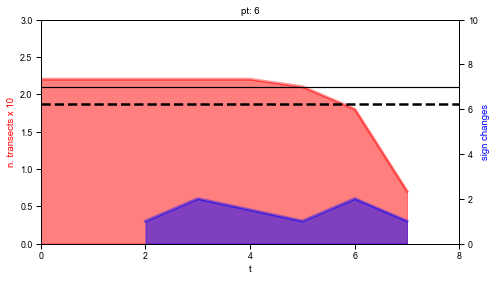

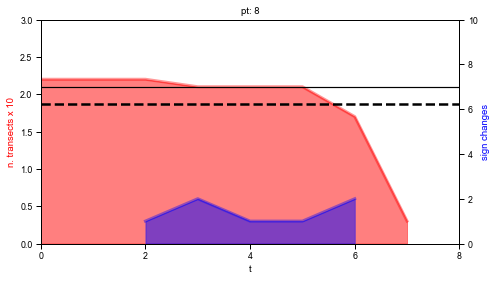

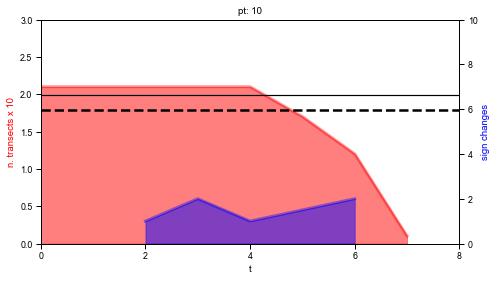

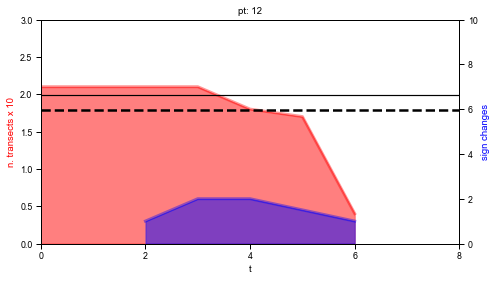

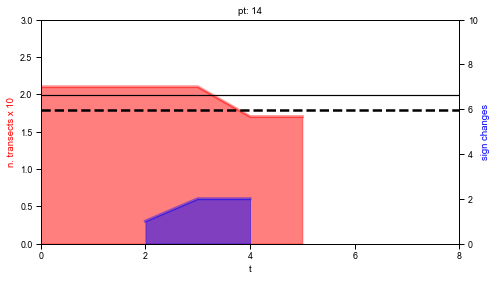

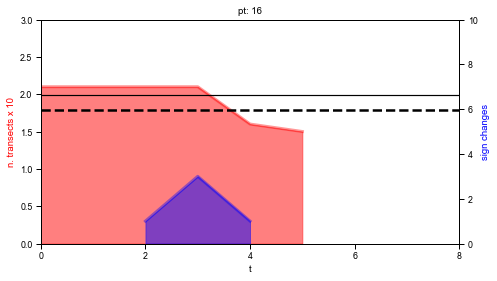

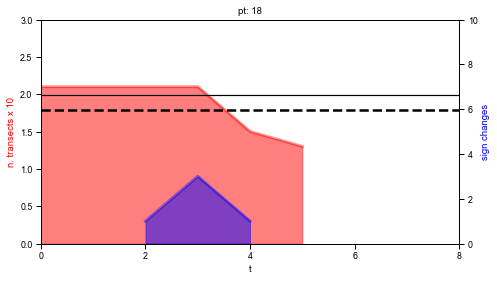

In [41]:
plot_sensitivity_rbcds_transects(ss_tr_big, location='mar')

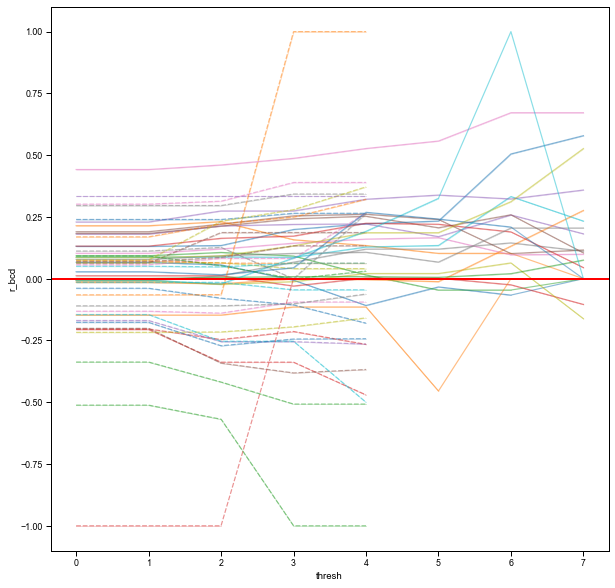

In [43]:
f,ax=plt.subplots(figsize=(10,10))

palette=sb.color_palette( n_colors=ss_tr_big.tr_id.unique().shape[0])
sb.lineplot(data=ss_tr_big, x='thresh',y='residual', hue='tr_id', style='location',
            palette=palette, legend=False, **dict(alpha=0.5),
            ax=ax
)
ax.set_ylabel("r_bcd")
ax.axhline(y=0, lw=2, c='r');

### ProfileSet

In [50]:
P=ProfileSet(dirNameDSM=dirNameDSM,
            dirNameOrtho=dirNameOrtho,
            dirNameTrans=dirNameTrans,
            transects_spacing=transects_spacing,
            loc_codes=loc_codes,
            loc_search_dict=loc_search_dict,
            crs_dict_string=crs_dict_string,
            check="all")

dsm from leo = 6

ortho from leo = 6

dsm from mar = 9

ortho from mar = 9


NUMBER OF DATASETS TO PROCESS: 30


In [51]:
P.extract_profiles(mode='all',tr_ids='tr_id',sampling_step=1,add_xy=True,lod_mode=lod_mode)

Extracting elevation from DSMs . . .


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=40.653104305267334 seconds
First 10 rows are printed below
Number of points outside the raster extents: 9066
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 250
The extraction assigns NaN.
Extracting rgb values from orthos . . .


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=42.107861280441284 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27198
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.
Extracting LoD values


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:1395
Time for processing=4.626348972320557 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.


#### Cleaning

In [52]:
from sandpyper.labels import get_sil_location, get_opt_k


In [53]:
# Run interatively KMeans + SA

feature_set=["band1","band2","band3","distance"]
sil_df=get_sil_location(P.profiles,
                        ks=(2,15), 
                        feature_set=feature_set,
                       random_state=10)
opt_k=get_opt_k(sil_df, sigma=0 )
opt_k

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Working on : mar, 20190516.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.6219865168763407
For n_clusters = 3 The average silhouette_score is : 0.535782834177223
For n_clusters = 4 The average silhouette_score is : 0.5360693626824162
For n_clusters = 5 The average silhouette_score is : 0.4560535847617118
For n_clusters = 6 The average silhouette_score is : 0.45529082978244856
For n_clusters = 7 The average silhouette_score is : 0.44623104595368007
For n_clusters = 8 The average silhouette_score is : 0.4276467073078296
For n_clusters = 9 The average silhouette_score is : 0.39984472497160034
For n_clusters = 10 The average silhouette_score is : 0.3944833658664287
For n_clusters = 11 The average silhouette_score is : 0.39290037915600995
For n_clusters = 12 The average silhouette_score is : 0.3626866522843635
For n_clusters = 13 The average silhouette_score is : 0.3537214969510808
For n_clusters = 14 The average silhouette_score is : 0.360049558138258
Working on : mar, 20190313.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.557958595647791
For n_clusters = 3 The average silhouette_score is : 0.5140648301846097
For n_clusters = 4 The average silhouette_score is : 0.5018436513556769
For n_clusters = 5 The average silhouette_score is : 0.433979206893076
For n_clusters = 6 The average silhouette_score is : 0.417124057365699
For n_clusters = 7 The average silhouette_score is : 0.41877526043796687
For n_clusters = 8 The average silhouette_score is : 0.3813644990945346
For n_clusters = 9 The average silhouette_score is : 0.38298598316290156
For n_clusters = 10 The average silhouette_score is : 0.38780357139523025
For n_clusters = 11 The average silhouette_score is : 0.3705944933198418
For n_clusters = 12 The average silhouette_score is : 0.3651637741592011
For n_clusters = 13 The average silhouette_score is : 0.3626901435079943
For n_clusters = 14 The average silhouette_score is : 0.364312347054231
Working on : mar, 20190205.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5864811907668233
For n_clusters = 3 The average silhouette_score is : 0.5287826504696901
For n_clusters = 4 The average silhouette_score is : 0.5135421029464969
For n_clusters = 5 The average silhouette_score is : 0.4307716357147362
For n_clusters = 6 The average silhouette_score is : 0.4198951039452866
For n_clusters = 7 The average silhouette_score is : 0.4216561839748987
For n_clusters = 8 The average silhouette_score is : 0.4048963177852256
For n_clusters = 9 The average silhouette_score is : 0.40309220394346107
For n_clusters = 10 The average silhouette_score is : 0.3863324302013023
For n_clusters = 11 The average silhouette_score is : 0.3797930282754271
For n_clusters = 12 The average silhouette_score is : 0.38096229910474133
For n_clusters = 13 The average silhouette_score is : 0.38270148296414735
For n_clusters = 14 The average silhouette_score is : 0.38101196831610196
Working on : mar, 20181211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5408421089322027
For n_clusters = 3 The average silhouette_score is : 0.5230591336669079
For n_clusters = 4 The average silhouette_score is : 0.5212604455141028
For n_clusters = 5 The average silhouette_score is : 0.4229400387683722
For n_clusters = 6 The average silhouette_score is : 0.45245862927127983
For n_clusters = 7 The average silhouette_score is : 0.4483238394769186
For n_clusters = 8 The average silhouette_score is : 0.4196417680949735
For n_clusters = 9 The average silhouette_score is : 0.40611511715414134
For n_clusters = 10 The average silhouette_score is : 0.38659542553842996
For n_clusters = 11 The average silhouette_score is : 0.3696055524901218
For n_clusters = 12 The average silhouette_score is : 0.37009962399500085
For n_clusters = 13 The average silhouette_score is : 0.35527656663572244
For n_clusters = 14 The average silhouette_score is : 0.3465435289160837
Working on : mar, 20181113.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5653353599190023
For n_clusters = 3 The average silhouette_score is : 0.48082172651613736
For n_clusters = 4 The average silhouette_score is : 0.4739355249881875
For n_clusters = 5 The average silhouette_score is : 0.44998542160594424
For n_clusters = 6 The average silhouette_score is : 0.46793686792032685
For n_clusters = 7 The average silhouette_score is : 0.45141377362406754
For n_clusters = 8 The average silhouette_score is : 0.4282875609756635
For n_clusters = 9 The average silhouette_score is : 0.41407851845524357
For n_clusters = 10 The average silhouette_score is : 0.40718423656045105
For n_clusters = 11 The average silhouette_score is : 0.3903647922431344
For n_clusters = 12 The average silhouette_score is : 0.3839833647433829
For n_clusters = 13 The average silhouette_score is : 0.38065272471925277
For n_clusters = 14 The average silhouette_score is : 0.3832072967705472
Working on : mar, 20180925.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5781993163219185
For n_clusters = 3 The average silhouette_score is : 0.5170856406873439
For n_clusters = 4 The average silhouette_score is : 0.48466929384434043
For n_clusters = 5 The average silhouette_score is : 0.4373504056027659
For n_clusters = 6 The average silhouette_score is : 0.39375906953445383
For n_clusters = 7 The average silhouette_score is : 0.38864190848914665
For n_clusters = 8 The average silhouette_score is : 0.4035256487664215
For n_clusters = 9 The average silhouette_score is : 0.3798356038299367
For n_clusters = 10 The average silhouette_score is : 0.37962054426443537
For n_clusters = 11 The average silhouette_score is : 0.3644375001522226
For n_clusters = 12 The average silhouette_score is : 0.3558265298038209
For n_clusters = 13 The average silhouette_score is : 0.34528697717595713
For n_clusters = 14 The average silhouette_score is : 0.35004508855406896
Working on : mar, 20180727.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5803251747670938
For n_clusters = 3 The average silhouette_score is : 0.48850610227959923
For n_clusters = 4 The average silhouette_score is : 0.4772654299979584
For n_clusters = 5 The average silhouette_score is : 0.4135001777584117
For n_clusters = 6 The average silhouette_score is : 0.38283314263428714
For n_clusters = 7 The average silhouette_score is : 0.3755827513627956
For n_clusters = 8 The average silhouette_score is : 0.3486272625814806
For n_clusters = 9 The average silhouette_score is : 0.3367906257895182
For n_clusters = 10 The average silhouette_score is : 0.3273888373123684
For n_clusters = 11 The average silhouette_score is : 0.30071888963336296
For n_clusters = 12 The average silhouette_score is : 0.3219840164575009
For n_clusters = 13 The average silhouette_score is : 0.3222155159146202
For n_clusters = 14 The average silhouette_score is : 0.307958370621084
Working on : mar, 20180621.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5439589764752933
For n_clusters = 3 The average silhouette_score is : 0.4387708619085413
For n_clusters = 4 The average silhouette_score is : 0.4501935908699898
For n_clusters = 5 The average silhouette_score is : 0.3963414382040067
For n_clusters = 6 The average silhouette_score is : 0.41807731086369254
For n_clusters = 7 The average silhouette_score is : 0.3871968978951222
For n_clusters = 8 The average silhouette_score is : 0.37393061831106983
For n_clusters = 9 The average silhouette_score is : 0.3443142601476958
For n_clusters = 10 The average silhouette_score is : 0.3585650473719073
For n_clusters = 11 The average silhouette_score is : 0.35570748604269775
For n_clusters = 12 The average silhouette_score is : 0.3575633171508779
For n_clusters = 13 The average silhouette_score is : 0.37087632012718563
For n_clusters = 14 The average silhouette_score is : 0.3795271430686032
Working on : mar, 20180601.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.48270415311106846
For n_clusters = 3 The average silhouette_score is : 0.3772084152830261
For n_clusters = 4 The average silhouette_score is : 0.38234628609235827
For n_clusters = 5 The average silhouette_score is : 0.38128225187445997
For n_clusters = 6 The average silhouette_score is : 0.36428432858349613
For n_clusters = 7 The average silhouette_score is : 0.36240034713437685
For n_clusters = 8 The average silhouette_score is : 0.3701424025696913
For n_clusters = 9 The average silhouette_score is : 0.37175207788683484
For n_clusters = 10 The average silhouette_score is : 0.37676977350569846
For n_clusters = 11 The average silhouette_score is : 0.37582649170780724
For n_clusters = 12 The average silhouette_score is : 0.3619596723553155
For n_clusters = 13 The average silhouette_score is : 0.360705274650356
For n_clusters = 14 The average silhouette_score is : 0.3549151019500089


  0%|          | 0/6 [00:00<?, ?it/s]

Working on : leo, 20190731.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3899198233106219
For n_clusters = 3 The average silhouette_score is : 0.5071438060156596
For n_clusters = 4 The average silhouette_score is : 0.47005119135652856
For n_clusters = 5 The average silhouette_score is : 0.4481907289981238
For n_clusters = 6 The average silhouette_score is : 0.42502882450684076
For n_clusters = 7 The average silhouette_score is : 0.4011433092740131
For n_clusters = 8 The average silhouette_score is : 0.38998808479733066
For n_clusters = 9 The average silhouette_score is : 0.38559916622535073
For n_clusters = 10 The average silhouette_score is : 0.38736594985557654
For n_clusters = 11 The average silhouette_score is : 0.3788805356672864
For n_clusters = 12 The average silhouette_score is : 0.37132878563783606
For n_clusters = 13 The average silhouette_score is : 0.3728000521740459
For n_clusters = 14 The average silhouette_score is : 0.37291633707910765
Working on : leo, 20190328.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3988524141238273
For n_clusters = 3 The average silhouette_score is : 0.4304685615621422
For n_clusters = 4 The average silhouette_score is : 0.431227035737659
For n_clusters = 5 The average silhouette_score is : 0.4509750902886234
For n_clusters = 6 The average silhouette_score is : 0.42012497505273527
For n_clusters = 7 The average silhouette_score is : 0.4094032569946379
For n_clusters = 8 The average silhouette_score is : 0.42729379253757904
For n_clusters = 9 The average silhouette_score is : 0.41690585873078206
For n_clusters = 10 The average silhouette_score is : 0.4226788217215935
For n_clusters = 11 The average silhouette_score is : 0.41351261817558693
For n_clusters = 12 The average silhouette_score is : 0.4087415403998031
For n_clusters = 13 The average silhouette_score is : 0.38543846003780563
For n_clusters = 14 The average silhouette_score is : 0.3783301865582882
Working on : leo, 20190211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3811803323084047
For n_clusters = 3 The average silhouette_score is : 0.48727929000883047
For n_clusters = 4 The average silhouette_score is : 0.44313687819005354
For n_clusters = 5 The average silhouette_score is : 0.45097582364485633
For n_clusters = 6 The average silhouette_score is : 0.4320727369612193
For n_clusters = 7 The average silhouette_score is : 0.4166514336483687
For n_clusters = 8 The average silhouette_score is : 0.39445247084076124
For n_clusters = 9 The average silhouette_score is : 0.3718047003108205
For n_clusters = 10 The average silhouette_score is : 0.36905766574894283
For n_clusters = 11 The average silhouette_score is : 0.3723670925736636
For n_clusters = 12 The average silhouette_score is : 0.35518841237259613
For n_clusters = 13 The average silhouette_score is : 0.35415290301652735
For n_clusters = 14 The average silhouette_score is : 0.33383141602938693
Working on : leo, 20180920.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4039166622963731
For n_clusters = 3 The average silhouette_score is : 0.4367493135688848
For n_clusters = 4 The average silhouette_score is : 0.42434419318841404
For n_clusters = 5 The average silhouette_score is : 0.4443994359362926
For n_clusters = 6 The average silhouette_score is : 0.4175864662989779
For n_clusters = 7 The average silhouette_score is : 0.38860870508958795
For n_clusters = 8 The average silhouette_score is : 0.38880003508342514
For n_clusters = 9 The average silhouette_score is : 0.3830287983992327
For n_clusters = 10 The average silhouette_score is : 0.37353163965128733
For n_clusters = 11 The average silhouette_score is : 0.36620965721819637
For n_clusters = 12 The average silhouette_score is : 0.3536600836899299
For n_clusters = 13 The average silhouette_score is : 0.3585083805642395
For n_clusters = 14 The average silhouette_score is : 0.35672016047028215
Working on : leo, 20180713.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.49629965872244686
For n_clusters = 3 The average silhouette_score is : 0.5092406492417487
For n_clusters = 4 The average silhouette_score is : 0.46159478658042724
For n_clusters = 5 The average silhouette_score is : 0.4488595142176017
For n_clusters = 6 The average silhouette_score is : 0.4183623304561938
For n_clusters = 7 The average silhouette_score is : 0.39004221840210485
For n_clusters = 8 The average silhouette_score is : 0.3842278112748862
For n_clusters = 9 The average silhouette_score is : 0.36304035595403583
For n_clusters = 10 The average silhouette_score is : 0.3463760386521644
For n_clusters = 11 The average silhouette_score is : 0.34841430296451464
For n_clusters = 12 The average silhouette_score is : 0.3460546307634773
For n_clusters = 13 The average silhouette_score is : 0.34457917043266856
For n_clusters = 14 The average silhouette_score is : 0.3318667826222712
Working on : leo, 20180606.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4012079287817844
For n_clusters = 3 The average silhouette_score is : 0.4563078554750914
For n_clusters = 4 The average silhouette_score is : 0.40640166442880776
For n_clusters = 5 The average silhouette_score is : 0.4001757072050638
For n_clusters = 6 The average silhouette_score is : 0.3890044660503746
For n_clusters = 7 The average silhouette_score is : 0.3716889344520391
For n_clusters = 8 The average silhouette_score is : 0.36600629265911533
For n_clusters = 9 The average silhouette_score is : 0.3503569988098764
For n_clusters = 10 The average silhouette_score is : 0.34651080656561367
For n_clusters = 11 The average silhouette_score is : 0.34322073624826754
For n_clusters = 12 The average silhouette_score is : 0.3439561998875081
For n_clusters = 13 The average silhouette_score is : 0.347961415981389
For n_clusters = 14 The average silhouette_score is : 0.33782737875946023


{'leo_20180606': 11,
 'leo_20180713': 10,
 'leo_20180920': 4,
 'leo_20190211': 4,
 'leo_20190328': 7,
 'leo_20190731': 9,
 'mar_20180601': 3,
 'mar_20180621': 3,
 'mar_20180727': 11,
 'mar_20180925': 7,
 'mar_20181113': 5,
 'mar_20181211': 5,
 'mar_20190205': 6,
 'mar_20190313': 6,
 'mar_20190516': 3}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle
from tqdm.notebook import tqdm

from sandpyper.profile import ProfileSet
from sandpyper.hotspot import ProfileDynamics

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
P=pickle.load(open(r"C:\my_packages\sandpyper\tests\test_data\test.p", "rb"))

In [3]:
opt_k={'leo_20180606': 11,
 'leo_20180713': 10,
 'leo_20180920': 4,
 'leo_20190211': 4,
 'leo_20190328': 7,
 'leo_20190731': 9,
 'mar_20180601': 3,
 'mar_20180621': 3,
 'mar_20180727': 11,
 'mar_20180925': 7,
 'mar_20181113': 5,
 'mar_20181211': 5,
 'mar_20190205': 6,
 'mar_20190313': 6,
 'mar_20190516': 3}

In [54]:
feature_set=["band1","band2","band3","distance"]

P.kmeans_sa(opt_k,feature_set)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [55]:
water_dict={'leo_20180606':[0,9,10],
'leo_20180713':[0,3,4,7],
'leo_20180920':[0,2,6,7],
'leo_20190211':[0,2,5],
'leo_20190328':[2,4,5],
'leo_20190731':[0,2,8,6],
'mar_20180601':[1,6],
'mar_20180621':[4,6],
'mar_20180727':[0,5,9,10],
'mar_20180925':[6],
'mar_20181113':[1],
'mar_20181211':[4],
'mar_20190205':[],
'mar_20190313':[],
'mar_20190516':[4,7]}

no_sand_dict={'leo_20180606':[5],
'leo_20180713':[],
'leo_20180920':[],
'leo_20190211':[1],
'leo_20190328':[],
'leo_20190731':[1],
'mar_20180601':[4,5],
'mar_20180621':[3,5],
'mar_20180727':[4,7],
'mar_20180925':[5],
'mar_20181113':[0],
'mar_20181211':[0],
'mar_20190205':[0,5],
'mar_20190313':[4],
'mar_20190516':[2,5]}

veg_dict={'leo_20180606':[1,3,7,8],
'leo_20180713':[1,5,9],
'leo_20180920':[1,4,5],
'leo_20190211':[4],
'leo_20190328':[0,1,6],
'leo_20190731':[3,7],
'mar_20180601':[0,7],
'mar_20180621':[1,7],
'mar_20180727':[1,3],
'mar_20180925':[1,3],
'mar_20181113':[3],
'mar_20181211':[2],
'mar_20190205':[3],
'mar_20190313':[1,5],
'mar_20190516':[0]}

sand_dict={'leo_20180606':[2,4,6],
'leo_20180713':[2,6,8],
'leo_20180920':[3],
'leo_20190211':[3],
'leo_20190328':[3],
'leo_20190731':[4,5],
'mar_20180601':[2,3],
'mar_20180621':[0,2],
'mar_20180727':[2,6,8],
'mar_20180925':[0,4,2],
'mar_20181113':[2,4],
'mar_20181211':[3,1],
'mar_20190205':[1,2,4],
'mar_20190313':[0,2,3],
'mar_20190516':[1,3,6]}


l_dicts={'no_sand': no_sand_dict,
         'sand': sand_dict,
        'water': water_dict,
        'veg':veg_dict}

In [56]:
label_corrections_path=r"C:\my_packages\sandpyper\tests\test_data\label_corrections.gpkg"
watermasks_path=r"C:\my_packages\sandpyper\tests\test_data\watermasks.gpkg"
shoremasks_path=r"C:\my_packages\sandpyper\tests\test_data\shoremasks.gpkg"

In [57]:
P.cleanit(l_dicts=l_dicts,
          watermasks_path=watermasks_path,
          shoremasks_path=shoremasks_path,
          label_corrections_path=label_corrections_path)

Reclassifying dataset with the provided dictionaries.
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
Label corrections provided in CRS: epsg:32754
Fine tuning in leo.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/6 [00:00<?, ?it/s]

Fine-tuning label_k 3 to no_sand in leo-20180606, found 127 pts.
Fine-tuning label_k 8 to no_sand in leo-20180606, found 73 pts.
Fine-tuning label_k 5 to no_sand in leo-20180713, found 56 pts.
Fine-tuning label_k 6 to no_sand in leo-20180713, found 7 pts.
Fine-tuning label_k 1 to no_sand in leo-20180920, found 89 pts.
Fine-tuning label_k 2 to sand in leo-20180920, found 9 pts.
Fine-tuning label_k 2 to veg in leo-20180920, found 31 pts.
Fine-tuning label_k 6 to sand in leo-20180920, found 17 pts.
Fine-tuning label_k 2 to veg in leo-20190211, found 2 pts.
Fine-tuning label_k 6 to veg in leo-20190211, found 29 pts.
Fine-tuning label_k 6 to no_sand in leo-20190211, found 2 pts.
Fine-tuning label_k 6 to veg in leo-20190211, found 6 pts.
Fine-tuning label_k 6 to sand in leo-20190211, found 28 pts.
Fine-tuning label_k 7 to no_sand in leo-20190211, found 41 pts.
Fine-tuning label_k 0 to sand in leo-20190328, found 6 pts.
Fine-tuning label_k 0 to no_sand in leo-20190328, found 52 pts.
Fine-tuni

  0%|          | 0/6 [00:00<?, ?it/s]

Fine-tuning label_k 3 to water in mar-20180601, found 163 pts.
Fine-tuning label_k 7 to no_sand in mar-20180601, found 15 pts.
Fine-tuning label_k 7 to sand in mar-20180601, found 53 pts.
Fine-tuning label_k 1 to sand in mar-20180621, found 48 pts.
Fine-tuning label_k 3 to sand in mar-20180621, found 42 pts.
Fine-tuning label_k 2 to water in mar-20180727, found 98 pts.
Fine-tuning label_k 4 to sand in mar-20180727, found 29 pts.
Fine-tuning label_k 2 to no_sand in mar-20181211, found 45 pts.
Fine-tuning label_k 1 to water in mar-20181211, found 149 pts.
Fine-tuning label_k 2 to water in mar-20190205, found 304 pts.
Fine-tuning label_k 3 to no_sand in mar-20190205, found 23 pts.
Fine-tuning label_k 2 to water in mar-20190313, found 100 pts.
Fine-tuning label_k 5 to no_sand in mar-20190313, found 77 pts.
<class 'geopandas.geodataframe.GeoDataFrame'>
watermask  provided in CRS: epsg:32754
Applying watermasks cleaning.
Watermasking in mar.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/9 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 750 pts overlapping provided watermasks.
Setting to water 532 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 710 pts overlapping provided watermasks.
Setting to water 532 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 599 pts overlapping provided watermasks.
Setting to water 557 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 339 pts overlapping provided watermasks.
Setting to water 133 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 441 pts overlapping provided watermasks.
Watermasking in leo.


  0%|          | 0/6 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 652 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 555 pts overlapping provided watermasks.
Setting to water 638 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 627 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 583 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 643 pts overlapping provided watermasks.
shoremask  provided in CRS: epsg:32754
Applying shoremasks cleaning.
Shoremasking in mar.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".jo

Removing 3621 pts falling outside provided shore polygones.
Shoremasking in leo.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Removing 2358 pts falling outside provided shore polygones.
['polygon finetuning', 'watermasking', 'shoremasking'] completed.


### ProfileDynamics

In [58]:
labels=["Undefined", "Small", "Medium", "High", "Extreme"]
appendix=["_deposition", "_erosion"]


D = ProfileDynamics(P, bins=5, method="JenksCaspall", labels=labels)

D.compute_multitemporal(loc_full={'mar': 'Marengo',
         'leo': 'St. Leonards'}, filter_class='sand')

D.LISA_site_level(mode="distance", distance_value=35)

D.discretise(absolute=True, print_summary=True, lod=D.lod_df)  # add lod option and hotspot options

D.infer_weights()

Data will be partitioned into 5 discrete classes.
Labels provided.
Filter activated: only ['sand'] points will be retained.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
done
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
done


  0%|          | 0/2 [00:00<?, ?it/s]

Working on mar


  0%|          | 0/8 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Working on leo


  0%|          | 0/5 [00:00<?, ?it/s]

              JenksCaspall              
 
Lower          Upper               Count
        x[i] <= 0.078               1192
0.078 < x[i] <= 0.166               1051
0.166 < x[i] <= 0.282                869
0.282 < x[i] <= 0.464                750
0.464 < x[i] <= 2.515                431

Fit of JenksCaspall with 5 bins: 154.3070259327069


LoD filter in use. Only points beyond LoDs will be retained.


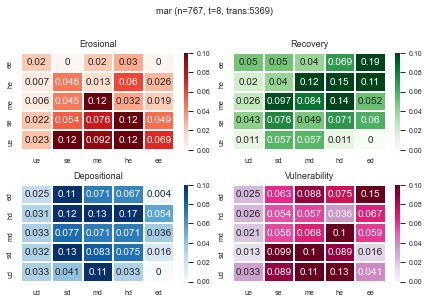

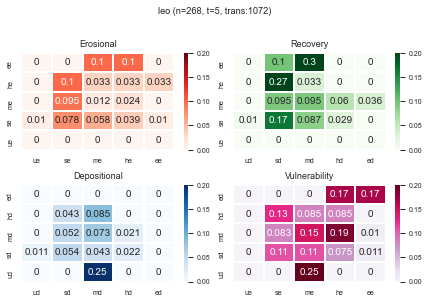

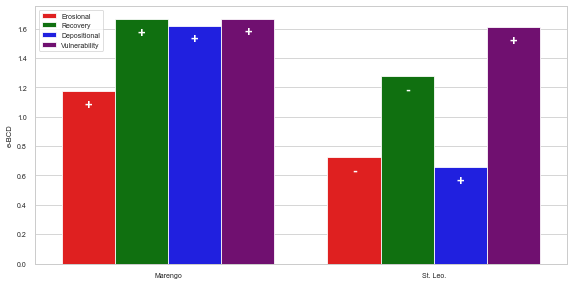

In [59]:
# lod
D.BCD_compute_location("geometry","all",True, filterit='lod')


D.plot_trans_matrices(relabel_dict)
D.plot_location_ebcds()

Hotspot filter in use. Only statistically significant clusters will be retained.


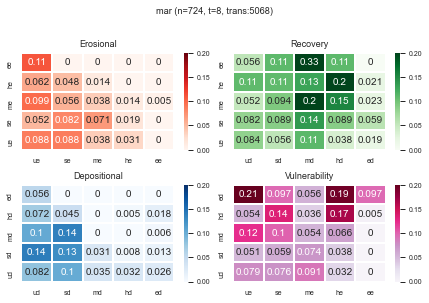

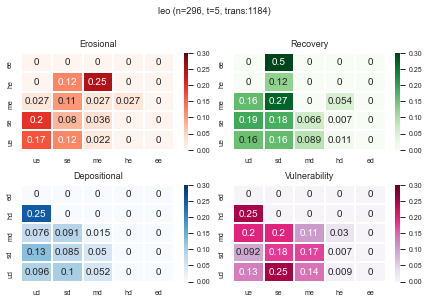

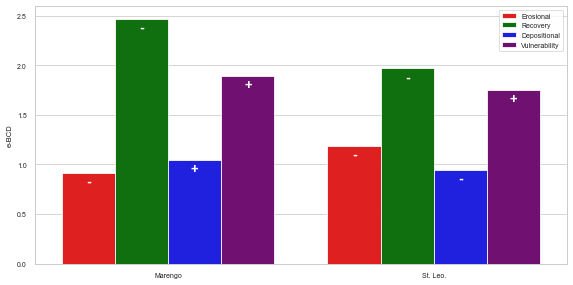

In [41]:
#hotspot

D.BCD_compute_location("geometry","all",True, filterit='hotspot')


D.plot_trans_matrices(relabel_dict)
D.plot_location_ebcds()

In [60]:
D.compute_volumetrics(lod=D.lod_df)

Using LoDs.


In [61]:
loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

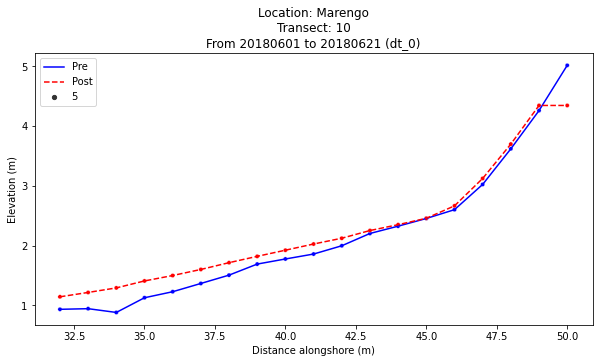

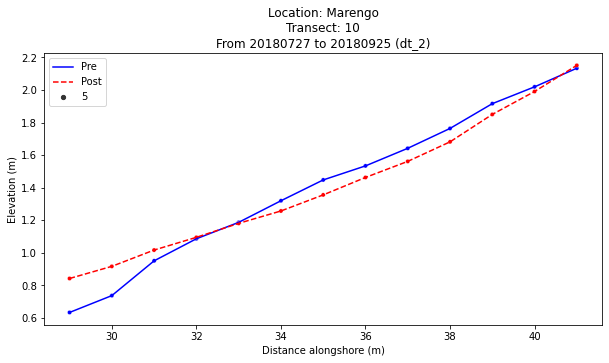

In [9]:
D.plot_transects(location='mar', tr_id=10, dt=['dt_0','dt_2'], classified=False)

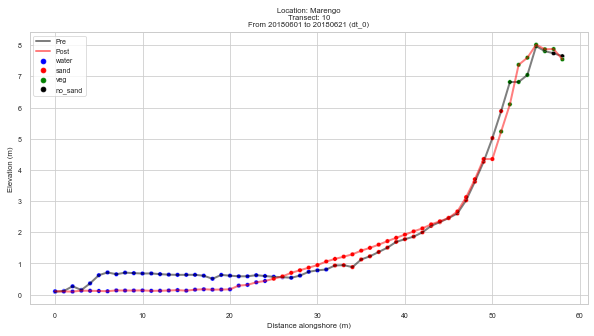

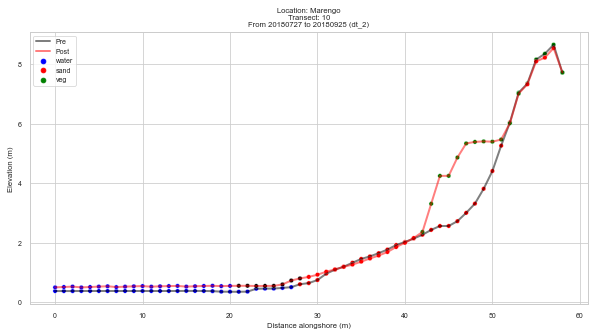

In [63]:
D.plot_transects(location='mar', tr_id=10, dt=['dt_0','dt_2'], classified=True)

Statistics are computed based on the following classes only: sand


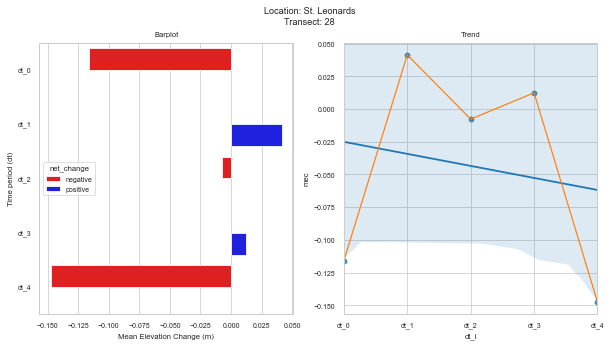

In [64]:
D.plot_transect_mecs(location='leo',tr_id=28)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


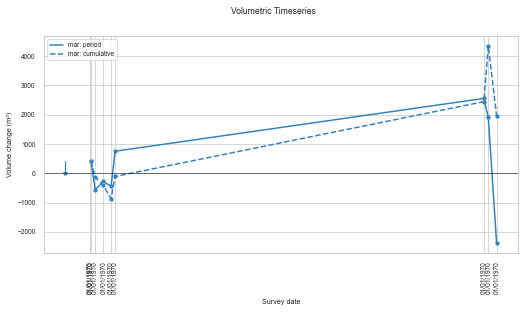

In [69]:
D.plot_single_loc(["mar"],None)

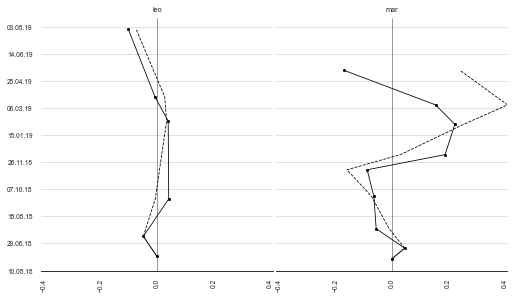

In [70]:
D.plot_mec_evolution(location_field="location",
                     loc_order=["leo","mar"])

In [4]:
loc_specs={'mar':{'thresh':6,
       'min_points':6}}

In [5]:
D.BCD_compute_transects(loc_specs=loc_specs,reliable_action='keep', dirNameTrans=D.ProfileSet.dirNameTrans)

  0%|          | 0/2 [00:00<?, ?it/s]

tr_id 24 has 0 valid points.
No threshold and mi_points provided in loc_specs for leo. Using no filters.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

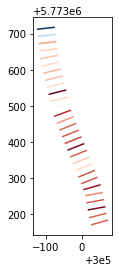

In [8]:
D.transects_rbcd.query("location=='leo'").plot(column="residual", cmap='RdBu_r')

### Save

In [72]:
dir_out=r'C:\my_packages\sandpyper\tests\test_data'
name="test"
D.save(name,dir_out)
D

ProfileDynamics object saved in C:\my_packages\sandpyper\tests\test_data\test.p .


### Load

In [73]:
D=pickle.load(open(r"C:\my_packages\sandpyper\tests\test_data\test.p", "rb"))

loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

___